In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import plot_tree


df = pd.read_csv('../../data/DATASET_FINAL_DIVORCIOS.csv')
df.head()


,Departamento,Divorcios,Denuncias,Sexo_Hombre,Sexo_Mujer,0 a 4,5 a 9,10 a 14,15 a 19,20 a 24,25 a 29,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 y más,Ignorado_edad
0,República,"91,536","484,607","52,835","431,772",530,"1,015","3,359","39,506","87,672","90,822","79,107","59,870","40,395","25,711","16,870","10,963","7,898","14,401","6,488"
1,Guatemala,"35,192","90,889","9,909","80,980",99,190,630,"7,409","16,443","17,034","14,837","11,229","7,576","4,822","3,164","2,056","1,481","2,701","1,217"
2,El Progreso,"1,577","15,295","1,668","13,627",17,32,106,"1,247","2,767","2,866","2,497","1,890","1,275",811,532,346,249,455,205
3,Sacatepéquez,"1,968","22,713","2,476","20,237",25,48,157,"1,852","4,109","4,257","3,708","2,806","1,893","1,205",791,514,370,675,304
4,Chimaltenango,"1,801","26,664","2,907","23,757",29,56,185,"2,174","4,824","4,997","4,353","3,294","2,223","1,415",928,603,435,792,357


In [2]:
# Ver dimensiones y tipos de datos
df.info()

# Verificar valores nulos
print(df.isnull().sum())

# Estadísticas generales
df.describe(include='all')

# Eliminar filas con valores nulos (opcional según el análisis)
df.dropna(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Departamento   24 non-null     object
 1   Divorcios      24 non-null     object
 2   Denuncias      24 non-null     object
 3   Sexo_Hombre    24 non-null     object
 4   Sexo_Mujer     24 non-null     object
 5   0 a 4          24 non-null     int64 
 6   5 a 9          24 non-null     object
 7   10 a 14        24 non-null     object
 8   15 a 19        24 non-null     object
 9   20 a 24        24 non-null     object
 10  25 a 29        24 non-null     object
 11  30 a 34        24 non-null     object
 12  35 a 39        24 non-null     object
 13  40 a 44        24 non-null     object
 14  45 a 49        24 non-null     object
 15  50 a 54        24 non-null     object
 16  55 a 59        24 non-null     object
 17  60 a 64        24 non-null     object
 18  65 y más       24 non-null     o

In [3]:
# Eliminar filas de totales nacionales si existen
df = df[df['Departamento'] != 'República']

# Reemplazar comas por nada y convertir a entero
cols_numericas = df.columns.drop('Departamento')
df[cols_numericas] = df[cols_numericas].replace(',', '', regex=True).astype(int)

# Crear la variable objetivo: "Categoria_Divorcios"
promedio_nacional = df['Denuncias'].mean()
df['Categoria_Denuncias'] = df['Denuncias'].apply(
    lambda x: 'alto' if x > promedio_nacional else ('bajo' if x < promedio_nacional else 'neutro')
)

In [4]:
# Verificar valores únicos
df['Categoria_Denuncias'].value_counts()

Categoria_Denuncias
bajo    15
alto     8
Name: count, dtype: int64

In [5]:
df.head()

,Departamento,Divorcios,Denuncias,Sexo_Hombre,Sexo_Mujer,0 a 4,5 a 9,10 a 14,15 a 19,20 a 24,...,30 a 34,35 a 39,40 a 44,45 a 49,50 a 54,55 a 59,60 a 64,65 y más,Ignorado_edad,Categoria_Denuncias
1,Guatemala,35192,90889,9909,80980,99,190,630,7409,16443,...,14837,11229,7576,4822,3164,2056,1481,2701,1217,alto
2,El Progreso,1577,15295,1668,13627,17,32,106,1247,2767,...,2497,1890,1275,811,532,346,249,455,205,bajo
3,Sacatepéquez,1968,22713,2476,20237,25,48,157,1852,4109,...,3708,2806,1893,1205,791,514,370,675,304,alto
4,Chimaltenango,1801,26664,2907,23757,29,56,185,2174,4824,...,4353,3294,2223,1415,928,603,435,792,357,alto
5,Escuintla,4131,15404,1679,13725,17,32,107,1256,2787,...,2515,1903,1284,817,536,348,251,458,206,bajo


In [6]:
# Variables X e y
X = df.drop(columns=['Departamento', 'Categoria_Denuncias', 'Denuncias'])  # No usamos Denuncias porque define la etiqueta
y = df['Categoria_Denuncias']

# Normalización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Codificación de la clase
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)


Accuracy: 1.0

Matriz de Confusión:
[[2 0]
 [0 5]]

Reporte de Clasificación:
              precision    recall  f1-score   support

        alto       1.00      1.00      1.00         2
        bajo       1.00      1.00      1.00         5

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



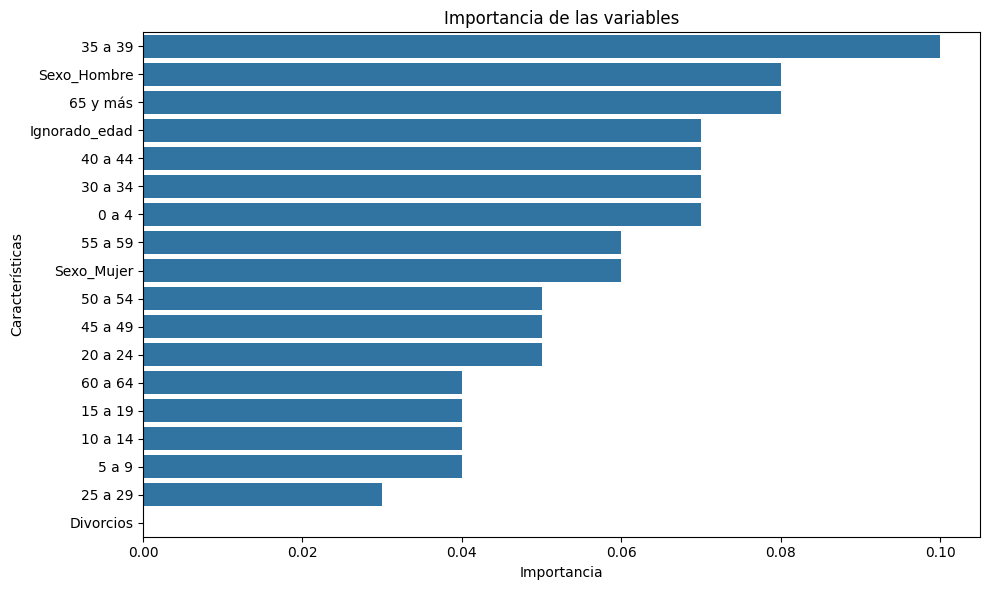


Precisión promedio (CV): 1.0000 (+/- 0.0000)


In [7]:
# Entrenar modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predicciones
y_pred = rf.predict(X_test)

# Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Importancia de características
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

# Visualización de importancias
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title('Importancia de las variables')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.tight_layout()
plt.show()

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X_scaled, y_encoded, cv=cv, scoring='accuracy')
print(f"\nPrecisión promedio (CV): {scores.mean():.4f} (+/- {scores.std():.4f})")


In [8]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


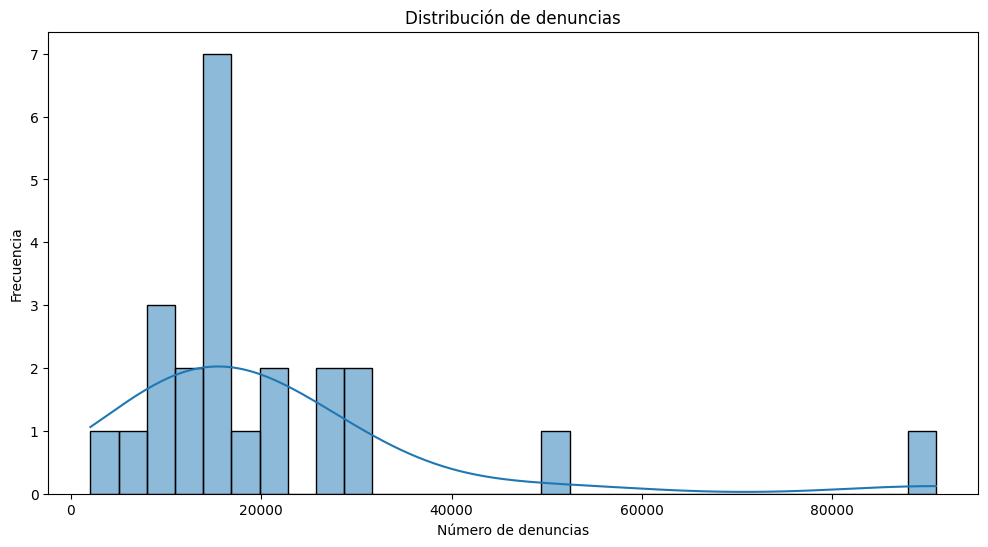

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Denuncias'], bins=30, kde=True)
plt.title('Distribución de denuncias')
plt.xlabel('Número de denuncias')
plt.ylabel('Frecuencia')
plt.show()


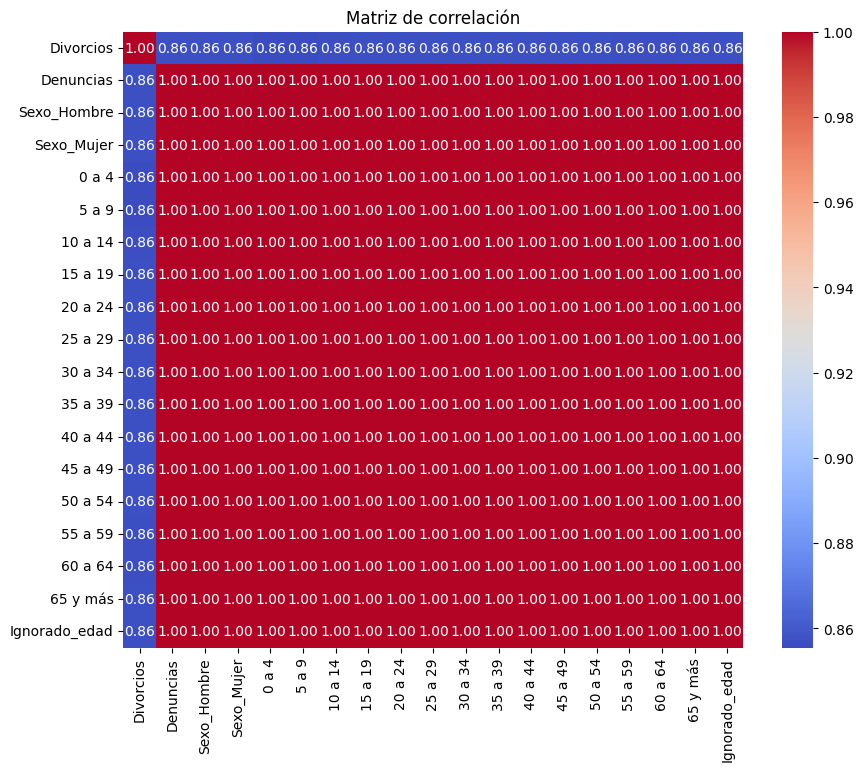

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[cols_numericas].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()


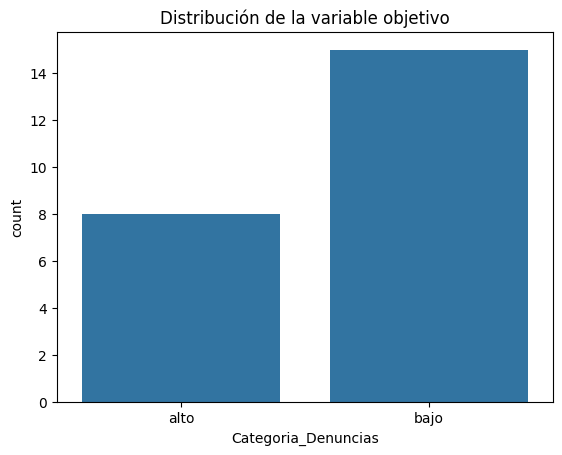

In [11]:
sns.countplot(x='Categoria_Denuncias', data=df)
plt.title('Distribución de la variable objetivo')
plt.show()


In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X_scaled, y_encoded, cv=cv, scoring='accuracy')
print(f"\nPrecisión promedio (CV): {scores.mean():.4f} (+/- {scores.std():.4f})")



Precisión promedio (CV): 1.0000 (+/- 0.0000)


In [13]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_scaled, y_encoded)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score:", grid_search.best_score_)


Mejores parámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Mejor score: 1.0


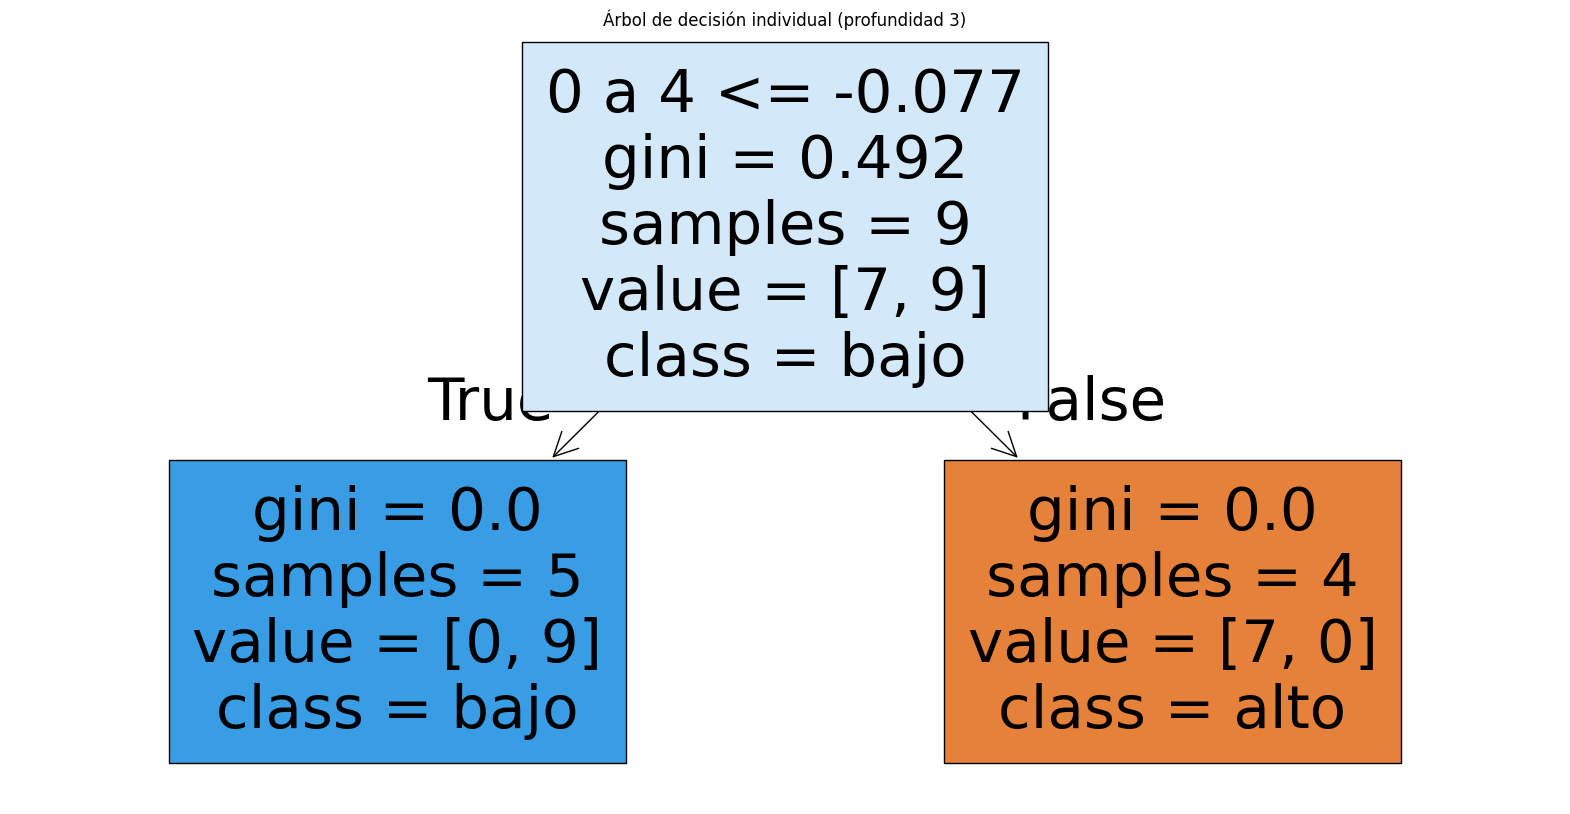

In [14]:
# Visualizar un árbol del bosque
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=X.columns, class_names=le.classes_, filled=True, max_depth=3)
plt.title("Árbol de decisión individual (profundidad 3)")
plt.show()


# Eliminando Multicolinealidad

In [15]:
# Primero: eliminar columnas con alta correlación
def eliminar_multicolinealidad_corr(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"Variables eliminadas por alta correlación (> {threshold}): {to_drop}")
    return df.drop(columns=to_drop), to_drop

# Segundo: eliminar columnas con VIF alto
def eliminar_multicolinealidad_vif(df, threshold=10.0):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    to_drop = vif_data[vif_data['VIF'] > threshold]['feature'].tolist()
    print(f"Variables eliminadas por VIF > {threshold}: {to_drop}")
    return df.drop(columns=to_drop), to_drop

# Escalamos de nuevo (por si los datos cambiaron)
scaler = StandardScaler()
X_scaled_df = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Aplicamos ambos métodos
X_corr_clean, dropped_corr = eliminar_multicolinealidad_corr(X_scaled_df, threshold=0.95)
X_vif_clean, dropped_vif = eliminar_multicolinealidad_vif(X_corr_clean, threshold=10.0)

# Resultado final
X_clean = X_vif_clean
print(f"Dimensiones originales: {X.shape}")
print(f"Dimensiones finales: {X_clean.shape}")


Variables eliminadas por alta correlación (> 0.95): ['Sexo_Mujer', '0 a 4', '5 a 9', '10 a 14', '15 a 19', '20 a 24', '25 a 29', '30 a 34', '35 a 39', '40 a 44', '45 a 49', '50 a 54', '55 a 59', '60 a 64', '65 y más', 'Ignorado_edad']
Variables eliminadas por VIF > 10.0: []
Dimensiones originales: (23, 18)
Dimensiones finales: (23, 2)


In [16]:
# Usar el X_clean sin multicolinealidad
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

rf_clean = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clean.fit(X_train, y_train)

y_pred = rf_clean.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nMatriz de Confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

# Validación cruzada
scores_clean = cross_val_score(rf_clean, X_clean, y_encoded, cv=5)
print(f"\nPrecisión promedio (CV): {scores_clean.mean():.4f} (+/- {scores_clean.std():.4f})")


Accuracy: 1.0

Matriz de Confusión:
 [[2 0]
 [0 5]]

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7


Precisión promedio (CV): 1.0000 (+/- 0.0000)
